# Package

In [2]:
%matplotlib inline

import re
import html
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import GridSearchCV
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
import nltk
nltk.download('punkt')
import spacy
spacy.require_gpu()
nlp = spacy.load('en_core_web_sm', disable=['tagger', 'parser', 'attribute_ruler', 'lemmatizer', 'ner'])

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


# Load Data

In [3]:
train_file_path = "/content/drive/MyDrive/DownDating_DataAnalyst_Homework_2023/dataset/train.csv"
test_file_path = "/content/drive/MyDrive/DownDating_DataAnalyst_Homework_2023/dataset/test.csv"

In [4]:
train_df = pd.read_csv(train_file_path, header=None, names=['label', 'content'], usecols=[0, 1])
# Reassign labels to adhere to Python conventions
train_df['label'] -= 1
# Create a human-readable label
classes = ['World', 'Sports', 'Business', 'Sci/Tech']
train_df['label_name'] = train_df.label.replace({i: classes[i] for i in range(4)})
train_df.head()

,label,content,label_name
0,2,Wall St. Bears Claw Back Into the Black (Reuters),Business
1,2,Carlyle Looks Toward Commercial Aerospace (Reu...,Business
2,2,Oil and Economy Cloud Stocks' Outlook (Reuters),Business
3,2,Iraq Halts Oil Exports from Main Southern Pipe...,Business
4,2,"Oil prices soar to all-time record, posing new...",Business


In [5]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 120000 entries, 0 to 119999
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   label       120000 non-null  int64 
 1   content     120000 non-null  object
 2   label_name  120000 non-null  object
dtypes: int64(1), object(2)
memory usage: 2.7+ MB


# Exploratory Data Analysis

In [6]:
# Get the distribution of labels
print("Distribution of labels:")
print(train_df["label_name"].value_counts())

Distribution of labels:
Business    30000
Sci/Tech    30000
Sports      30000
World       30000
Name: label_name, dtype: int64


The even distribution of the four labels is a positive indicator for a classification task. Now, let's delve into the analysis of content.

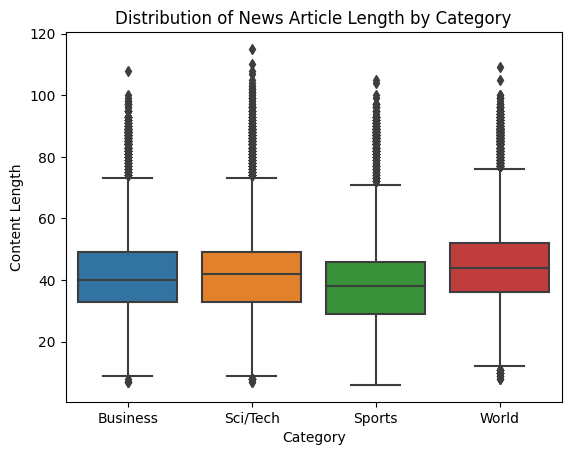

In [7]:
# Explore the length of news articles
train_df['content_length'] = train_df['content'].apply(len)
sns.boxplot(x='label_name', y='content_length', data=train_df)
plt.title('Distribution of News Article Length by Category')
plt.xlabel('Category')
plt.ylabel('Content Length')
plt.show()

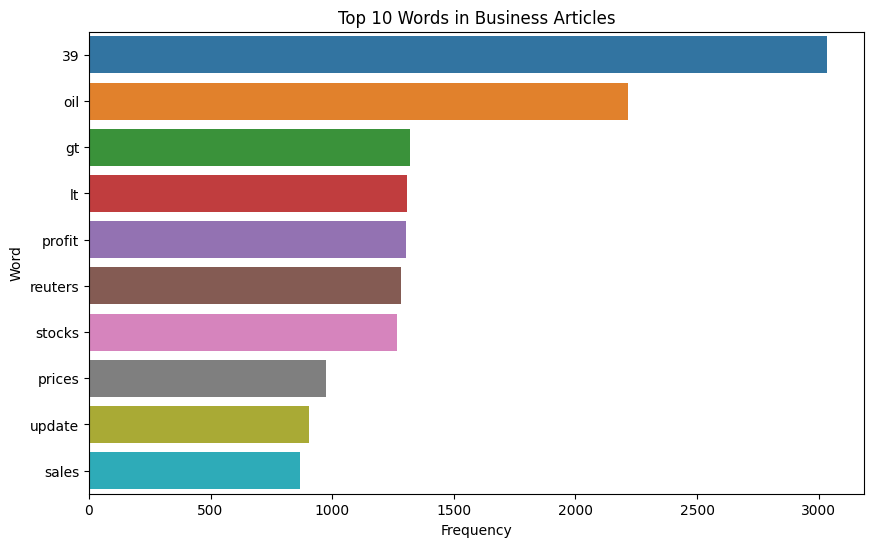

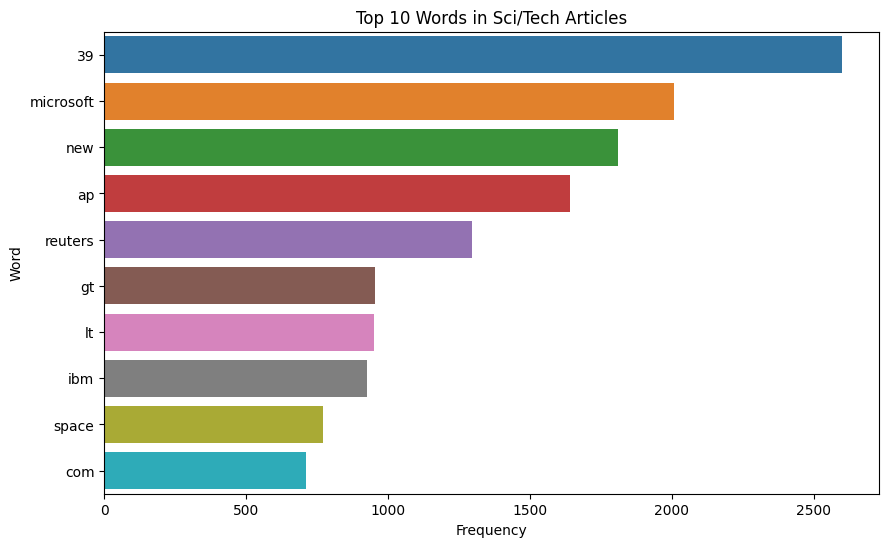

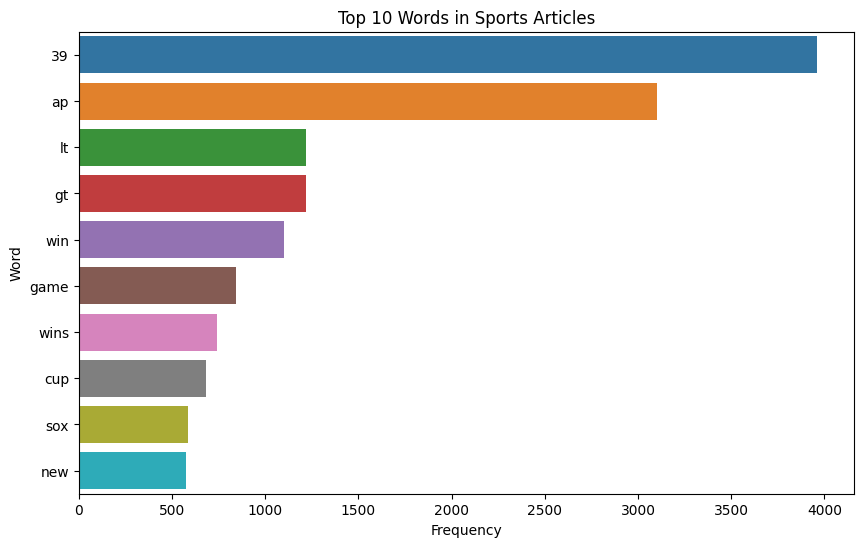

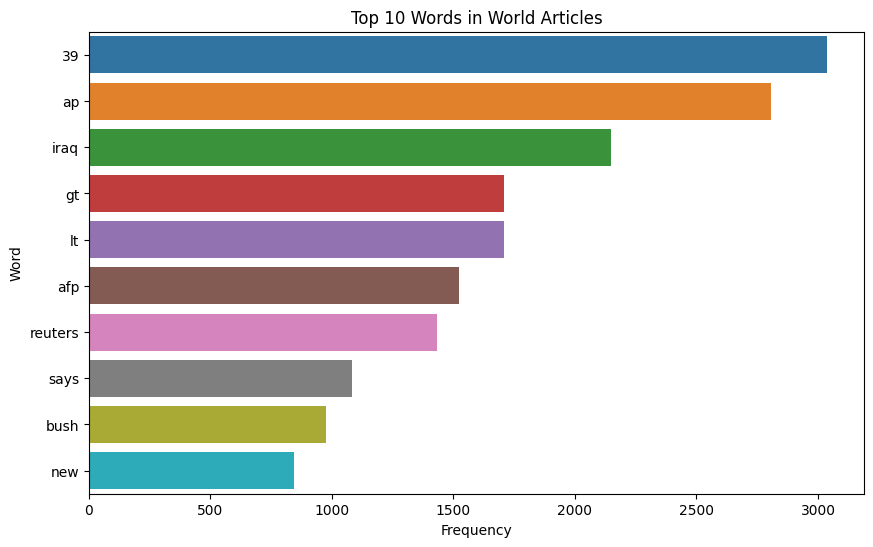

In [8]:
# Explore word frequency
def plot_top_words_per_category(category):
    corpus = train_df[train_df['label_name'] == category]['content']
    vectorizer = CountVectorizer(stop_words='english')
    X = vectorizer.fit_transform(corpus)
    word_freq = np.array(X.sum(axis=0))[0]
    words = np.array(vectorizer.get_feature_names_out())
    sorted_indices = np.argsort(word_freq)[::-1]

    plt.figure(figsize=(10, 6))
    sns.barplot(x=word_freq[sorted_indices][:10], y=words[sorted_indices][:10])
    plt.title(f'Top 10 Words in {category} Articles')
    plt.xlabel('Frequency')
    plt.ylabel('Word')

# Plot top words for each category
for category in train_df['label_name'].unique():
    plot_top_words_per_category(category)

The analysis of the top 10 frequently occurring words within each category reveals distinctive patterns that illuminate the relationship between terms and their respective groups. In the Business category, prevalent words such as 'oil,' 'stock,' and 'price' characterize the discourse, while the Sci/Tech category prominently features terms like 'Microsoft' and 'IBM.' However, commonalities emerge as certain words, such as 'AP,' 'Reuters,' and seemingly irrelevant ones like '39,' transcend across multiple categories. This suggests the presence of words that dominate universally.

To discern the truly significant words within each category and mitigate the impact of common terms, we proceed to further clean the content. Employing TF-IDF analysis allows us to identify and emphasize influential words specific to each category, thereby refining our understanding of the distinctive language patterns within the dataset.

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


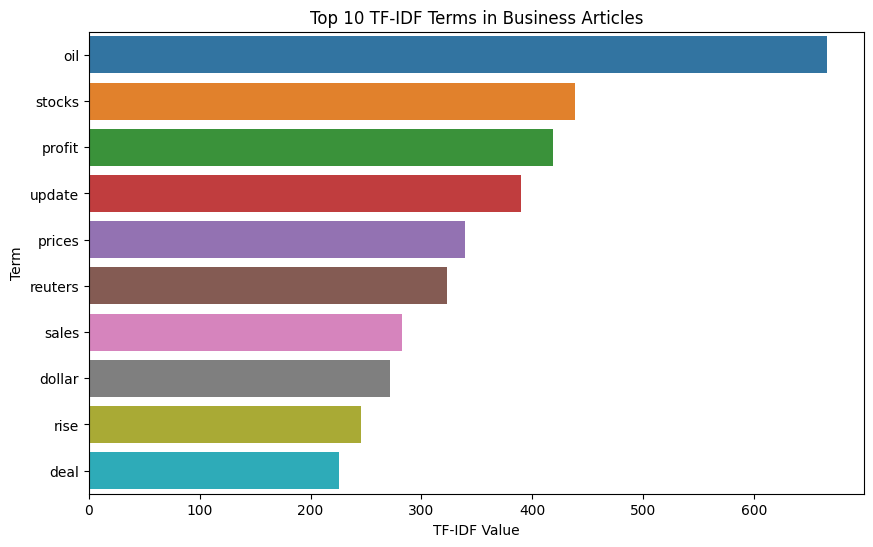

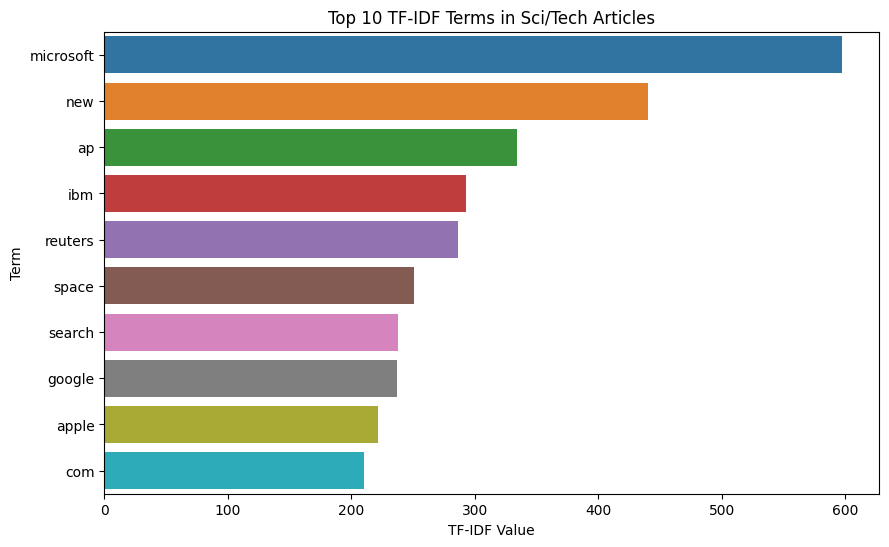

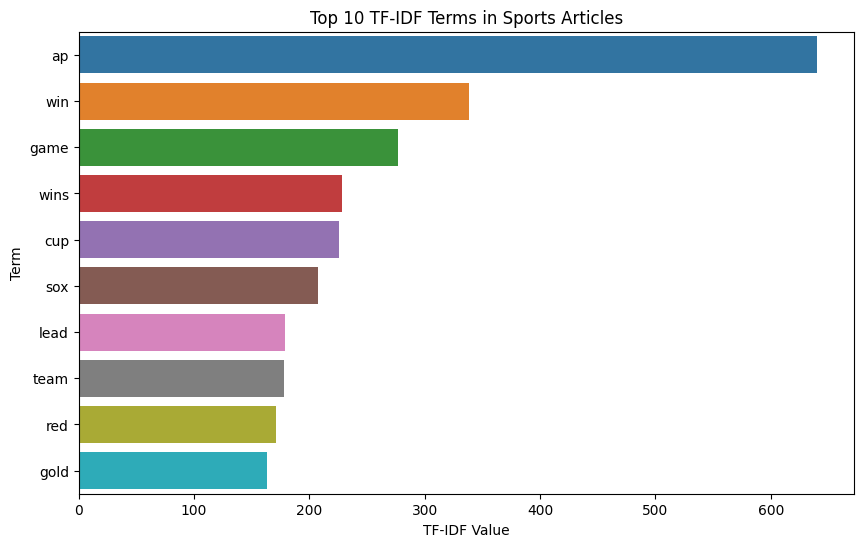

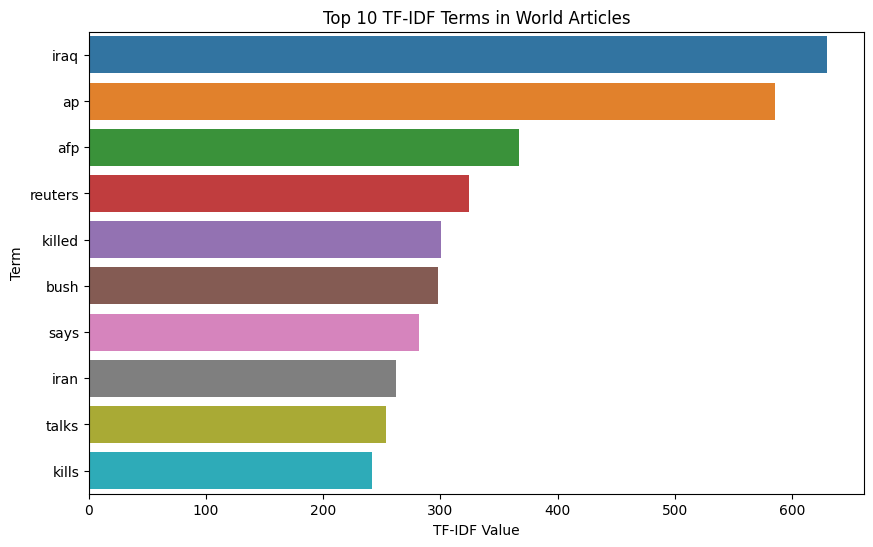

In [9]:
def custom_tokenizer(text, min_word_length=2):
    # Decode HTML entities
    text = html.unescape(text)
    # Remove HTML tags
    text = re.sub(r'<.*?>', '', text)
    # Remove digits
    text = re.sub(r'\d', '', text)
    # Remove punctuation and convert to lowercase
    text = re.sub(r'[^\w\s]', ' ', text.lower())
    # Tokenize the cleaned text and filter out short words
    tokens = [word for word in text.split() if len(word) >= min_word_length]

    return tokens

# TF-IDF Vectorization
tfidf_vectorizer = TfidfVectorizer(tokenizer=custom_tokenizer, stop_words='english')
X_tfidf = tfidf_vectorizer.fit_transform(train_df['content'])

# Identify top TF-IDF terms for each category
def top_tfidf_terms_per_category(category):
    indices = train_df[train_df['label_name'] == category].index
    tfidf_values = X_tfidf[indices].sum(axis=0).A1
    terms = np.array(tfidf_vectorizer.get_feature_names_out())
    sorted_indices = np.argsort(tfidf_values)[::-1]

    top_terms = terms[sorted_indices][:10]
    top_tfidf_values = tfidf_values[sorted_indices][:10]

    plt.figure(figsize=(10, 6))
    sns.barplot(x=top_tfidf_values, y=top_terms)
    plt.title(f'Top 10 TF-IDF Terms in {category} Articles')
    plt.xlabel('TF-IDF Value')
    plt.ylabel('Term')
    plt.show()

# Plot top TF-IDF terms for each category
for category in train_df['label_name'].unique():
    top_tfidf_terms_per_category(category)

After decoding HTML entities, eliminating HTML tags, punctuations, and digits, the top 10 frequent words exhibit more coherent patterns. The application of TF-IDF further enhances the significance of meaningful terms, bringing them to the forefront. However, the persistence of news publisher names in the top 10 suggests a potential influence on the results.

Creating a custom stop word list to exclude these publisher names is a viable option. However, it may be judicious to pause at this stage and consider addressing this issue during the training process. By incorporating this concern into the training phase, we can develop a more nuanced approach to handling publisher names and ensure a more accurate representation of the content's significance.

# Bonus: Classification Model
With TF-IDF, we can now construct a basic classification model using the Naive Bayes algorithm. As observed earlier, the class distribution is balanced, allowing us to employ accuracy as a suitable metric to assess the model's performance.

In [10]:
# Read the test dataset
test_df = pd.read_csv(test_file_path, header=None, names=['label', 'content'], usecols=[0, 1])
test_df['label'] -= 1  # Relabel to adhere to Python conventions

# Split the data into training and testing sets
X_train, y_train = train_df['content'], train_df['label']
X_test, y_test = test_df['content'], test_df['label']

In [28]:
# Vectorize the text data
vectorizer = TfidfVectorizer(tokenizer=custom_tokenizer, stop_words='english')
X_train_vectorized = vectorizer.fit_transform(X_train)
X_test_vectorized = vectorizer.transform(X_test)

# Train a Naive Bayes classifier
clf = MultinomialNB()
clf.fit(X_train_vectorized, y_train)

# Predictions on the training set
y_pred_train = clf.predict(X_train_vectorized)
# Predictions on the test set
y_pred_test = clf.predict(X_test_vectorized)

# Evaluate the model on the training set
accuracy_train = accuracy_score(y_train, y_pred_train)
classification_rep_train = classification_report(y_train, y_pred_train)

# Evaluate the model on the test set
accuracy_test = accuracy_score(y_test, y_pred_test)
classification_rep_test = classification_report(y_test, y_pred_test)

print('--- Train Result ---')
print(f'Accuracy: {accuracy_train:.2f}')
print('\nClassification Report:')
print(classification_rep_train)

print('\n--- Test Result ---')
print(f'Accuracy: {accuracy_test:.2f}')
print('\nClassification Report:')
print(classification_rep_test)

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


--- Train Result ---
Accuracy: 0.89

Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.89      0.90     30000
           1       0.93      0.95      0.94     30000
           2       0.86      0.87      0.87     30000
           3       0.88      0.87      0.87     30000

    accuracy                           0.89    120000
   macro avg       0.89      0.89      0.89    120000
weighted avg       0.89      0.89      0.89    120000


--- Test Result ---
Accuracy: 0.86

Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.87      0.87      1900
           1       0.91      0.92      0.92      1900
           2       0.84      0.82      0.83      1900
           3       0.85      0.84      0.85      1900

    accuracy                           0.86      7600
   macro avg       0.86      0.86      0.86      7600
weighted avg       0.86      0.86      0.86      7600



The training accuracy achieves a promising 89%, reflecting a strong initial result. Furthermore, the test accuracy of 86% suggests that overfitting is not apparent. To further refine performance, we consider stemming words and adjusting parameters in the TF-IDF vectorization process. By incorporating n-grams with a range of (1,2) and filtering out common words using max_df, we aim to enhance the model's ability to capture more nuanced relationships within the text data.

In [44]:
def custom_tokenizer2(text, min_word_length=2, use_stemming=True):
    # Decode HTML entities and remove HTML tags
    text = re.sub(r'<.*?>', '', html.unescape(text))
    # Remove digits
    text = re.sub(r'\d', '', text)
    # Remove punctuation and convert to lowercase
    text = re.sub(r'[^\w\s]', ' ', text.lower())
    # Tokenize the cleaned text
    tokens = word_tokenize(text)
    # Apply stemming using Porter Stemmer
    if use_stemming:
        stemmer = PorterStemmer()
        tokens = [stemmer.stem(word) for word in tokens]
    # Filter out short words
    tokens = [word for word in tokens if len(word) >= min_word_length]

    return tokens

# Define the pipeline with TfidfVectorizer and MultinomialNB
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(tokenizer=custom_tokenizer2, stop_words='english',
                              ngram_range=(1, 2))),
    ('classifier', MultinomialNB())
])

# Define the parameter grid for TfidfVectorizer
param_grid = {
    'tfidf__max_df': [0.1, 0.3, 0.5, 0.7, 0.9]
}

# Use GridSearchCV on the pipeline
grid_search = GridSearchCV(pipeline, param_grid, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train, y_train)

# Display detailed results for each parameter set
results_df = pd.DataFrame(grid_search.cv_results_)
print(results_df[['param_tfidf__max_df', 'mean_test_score', 'std_test_score', 'rank_test_score']])

# Extract the best model from the grid search
best_model = grid_search.best_estimator_

# Predictions on the training set
y_pred_train = best_model.predict(X_train)
# Predictions on the test set
y_pred_test = best_model.predict(X_test)

# Evaluate the model on the training set
accuracy_train = accuracy_score(y_train, y_pred_train)
classification_rep_train = classification_report(y_train, y_pred_train)

# Evaluate the model on the test set
accuracy_test = accuracy_score(y_test, y_pred_test)
classification_rep_test = classification_report(y_test, y_pred_test)

print('\n--- Train Result ---')
print(f'Accuracy: {accuracy_train:.2f}')
print('\nClassification Report:')
print(classification_rep_train)

print('\n--- Test Result ---')
print(f'Accuracy: {accuracy_test:.2f}')
print('\nClassification Report:')
print(classification_rep_test)

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:409: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abov', 'afterward', 'alon', 'alreadi', 'alway', 'ani', 'anoth', 'anyon', 'anyth', 'anywher', 'becam', 'becaus', 'becom', 'befor', 'besid', 'cri', 'describ', 'dure', 'els', 'elsewher', 'empti', 'everi', 'everyon', 'everyth', 'everywher', 'fifti', 'formerli', 'forti', 'ha', 'henc', 'hereaft', 'herebi', 'hi', 'howev', 'hundr', 'inde', 'latterli', 'mani', 'meanwhil', 'moreov', 'mostli', 'nobodi', 'noon', 'noth', 'nowher', 'onc', 'onli', 'otherwis', 'ourselv', 'perhap', 'pleas', 'seriou', 'sever', 'sinc', 'sincer', 'sixti', 'someon', 'someth', 'sometim', 'somewher', 'themselv', 'thenc', 'thereaft', 'therebi', '

  param_tfidf__max_df  mean_test_score  std_test_score  rank_test_score
0                 0.1         0.844558         0.01108                1
1                 0.3         0.844558         0.01108                1
2                 0.5         0.844558         0.01108                1
3                 0.7         0.844558         0.01108                1
4                 0.9         0.844558         0.01108                1
--- Train Result ---
Accuracy: 0.94

Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.92      0.94     30000
           1       0.96      0.97      0.97     30000
           2       0.92      0.92      0.92     30000
           3       0.93      0.93      0.93     30000

    accuracy                           0.94    120000
   macro avg       0.94      0.94      0.94    120000
weighted avg       0.94      0.94      0.94    120000


--- Test Result ---
Accuracy: 0.87

Classification Report:
             